In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import timm
import random
import time

# GPU 이용가능한 리눅스 환경인 경우 tsnecuda, 그렇지 않은 경우 sklearn 사용
# from tsnecuda import TSNE 
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

from torchvision.models import wide_resnet50_2
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(config.seed)

In [4]:
df = pd.read_csv('./train_df.csv')
df.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [5]:
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      4277 non-null   int64 
 1   file_name  4277 non-null   object
 2   class      4277 non-null   object
 3   state      4277 non-null   object
 4   label      4277 non-null   object
dtypes: int64(1), object(4)
memory usage: 167.2+ KB


In [6]:
print(len(df['class'].unique()))
df['class'].unique()

15


array(['transistor', 'capsule', 'wood', 'bottle', 'screw', 'cable',
       'carpet', 'hazelnut', 'pill', 'metal_nut', 'zipper', 'leather',
       'toothbrush', 'tile', 'grid'], dtype=object)

In [7]:
print(len(df['state'].unique()))
df['state'].unique()[:10]

49


array(['good', 'bent_wire', 'hole', 'pill_type', 'scratch', 'thread_side',
       'fabric_border', 'crack', 'manipulated_front', 'contamination'],
      dtype=object)

In [8]:
# 'state-class' => 'label' 형태
print(len(df['label'].unique()))
df['label'].unique()[:10]

88


array(['transistor-good', 'capsule-good', 'wood-good', 'bottle-good',
       'screw-good', 'cable-bent_wire', 'carpet-hole', 'hazelnut-good',
       'pill-pill_type', 'cable-good'], dtype=object)

In [9]:
uniqeu_states_dict = {val:idx for idx,val in enumerate(df['state'].unique())}
uniqeu_classes_dict = {val:idx for idx,val in enumerate(df['class'].unique())}
uniqeu_labels_dict = {val:idx for idx,val in enumerate(df['label'].unique())}

In [10]:
train_dirs = sorted(glob('./train/*.png'))

In [11]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img

In [12]:
train_imgs,states,classes,labels = [],[],[],[]
for i in range(len(df)):
    train_imgs.append(img_load(train_dirs[i]))
    states.append(uniqeu_states_dict[df['state'][i]])
    classes.append(uniqeu_classes_dict[df['class'][i]])
    labels.append(uniqeu_labels_dict[df['label'][i]])

In [13]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label

In [14]:
batch_size = 32
epochs = 25

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [15]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [16]:
from efficientnet_pytorch import EfficientNet

In [17]:
efficient_model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=88)

Loaded pretrained weights for efficientnet-b1


In [18]:
device = torch.device('cuda')

In [19]:
efficient_model.to(device)

optimizer = torch.optim.Adam(efficient_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 

In [23]:
best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    efficient_model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = efficient_model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/25    time : 81s/1945s
TRAIN    loss : 1.05122    f1 : 0.18321
epoch : 2/25    time : 65s/1502s
TRAIN    loss : 0.54081    f1 : 0.31821
epoch : 3/25    time : 65s/1428s
TRAIN    loss : 0.41040    f1 : 0.41754
epoch : 4/25    time : 65s/1366s
TRAIN    loss : 0.33982    f1 : 0.52085
epoch : 5/25    time : 65s/1300s
TRAIN    loss : 0.26436    f1 : 0.62650
epoch : 6/25    time : 66s/1246s
TRAIN    loss : 0.24466    f1 : 0.67357
epoch : 7/25    time : 66s/1181s
TRAIN    loss : 0.21016    f1 : 0.71910
epoch : 8/25    time : 65s/1112s
TRAIN    loss : 0.19288    f1 : 0.72868
epoch : 9/25    time : 65s/1039s
TRAIN    loss : 0.18401    f1 : 0.76207
epoch : 10/25    time : 65s/981s
TRAIN    loss : 0.13664    f1 : 0.82120
epoch : 11/25    time : 65s/915s
TRAIN    loss : 0.10728    f1 : 0.85186
epoch : 12/25    time : 66s/857s
TRAIN    loss : 0.09404    f1 : 0.86651
epoch : 13/25    time : 66s/790s
TRAIN    loss : 0.09582    f1 : 0.85768
epoch : 14/25    time : 65s/720s
TRAIN    loss : 0.

In [24]:
efficient_model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [82]:
print(torch.cuda.memory_allocated(),torch.cuda.memory_reserved())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(),torch.cuda.memory_reserved())

8598914560 15699279872
8598914560 9963569152


In [39]:
efficient_model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [125]:
val_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

In [126]:
results = []
with torch.no_grad():
    for batch in (val_loader):
        x = torch.tensor(batch[0],dtype=torch.float32, device=device)
        with torch.cuda.amp.autocast():
            pred = efficient_model.extract_features(x)
            pred.detach()
            result = pred.flatten(start_dim=1)
        results.extend(result)

In [127]:
# 결과를 array 형태로 변환합니다.
results_stack = torch.stack(results)
results_array = np.array(results_stack.cpu())

In [128]:
print(results_array.shape)

(4277, 327680)


In [129]:
print(len(results_array[0]))

327680


In [130]:
tsne_model = TSNE()
train_tsne = tsne_model.fit_transform(results_array)

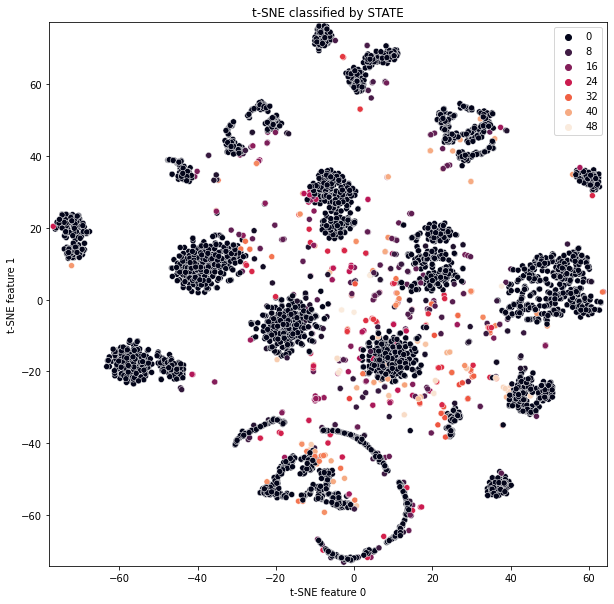

In [131]:
hue = states
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by STATE')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

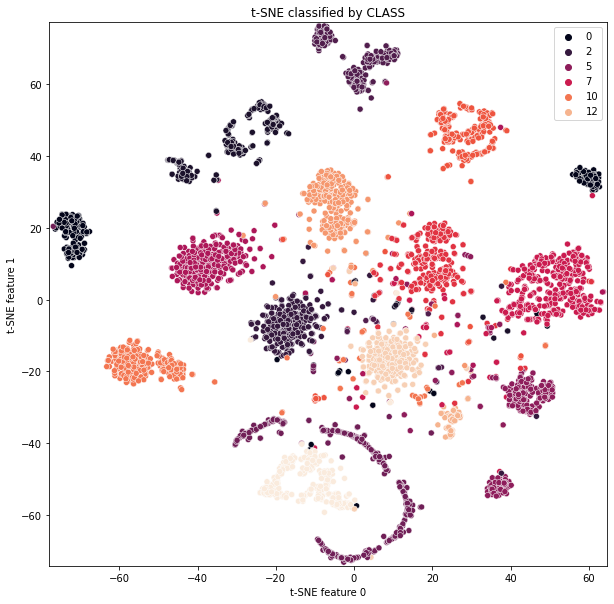

In [132]:
hue = classes
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by CLASS')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

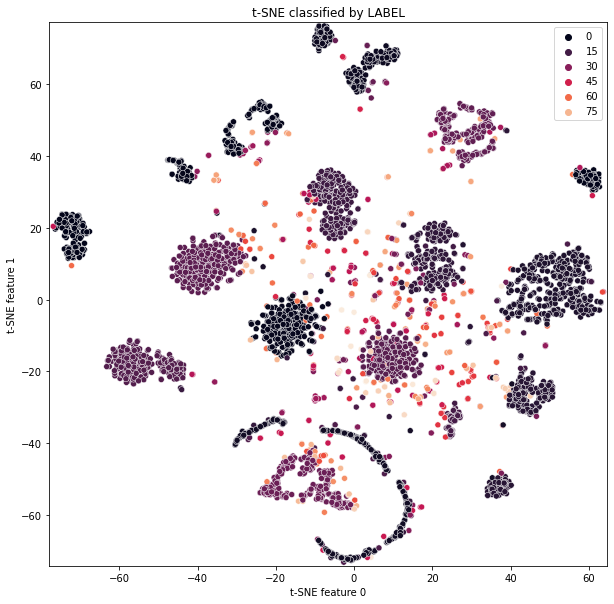

In [133]:
hue = labels
plt.figure(figsize=(10,10))
plt.xlim(train_tsne[:,0].min()-1,train_tsne[:,0].max()+1)
plt.ylim(train_tsne[:,1].min()-1,train_tsne[:,1].max()+1)
sns.scatterplot(train_tsne[:,0], train_tsne[:,1], hue=hue,
                palette="rocket")
plt.title('t-SNE classified by LABEL')
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.show()

In [134]:
# 클러스터링 평가
classifier = KNeighborsClassifier(n_neighbors=1)
print(cross_val_score(classifier, train_tsne, labels, cv=5).mean())

0.904836038694868


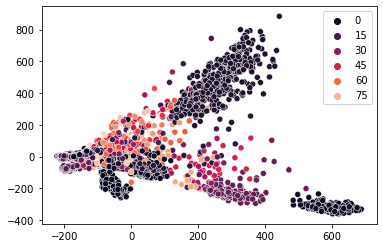

0.7537998032464338


In [135]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(results_array)

sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels,
                palette="rocket")
plt.show()

classifier = KNeighborsClassifier(n_neighbors=1)
print(cross_val_score(classifier, X_pca, labels, cv=5).mean())